In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [6]:
df = load_pd_df("df_analysis.feather")

# Macro Time Series Error analysis

## Cross corr

In [7]:
sub = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_MY', 'pi_perc_MY_all_error_act_MY', 'pi_de_surprise_Y', 'pi_de_Y',]
].drop_duplicates()
sub2 = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_WY', 'pi_perc_MY_all_error_act_WY', 'T_sum_diff_lag']
].drop_duplicates()

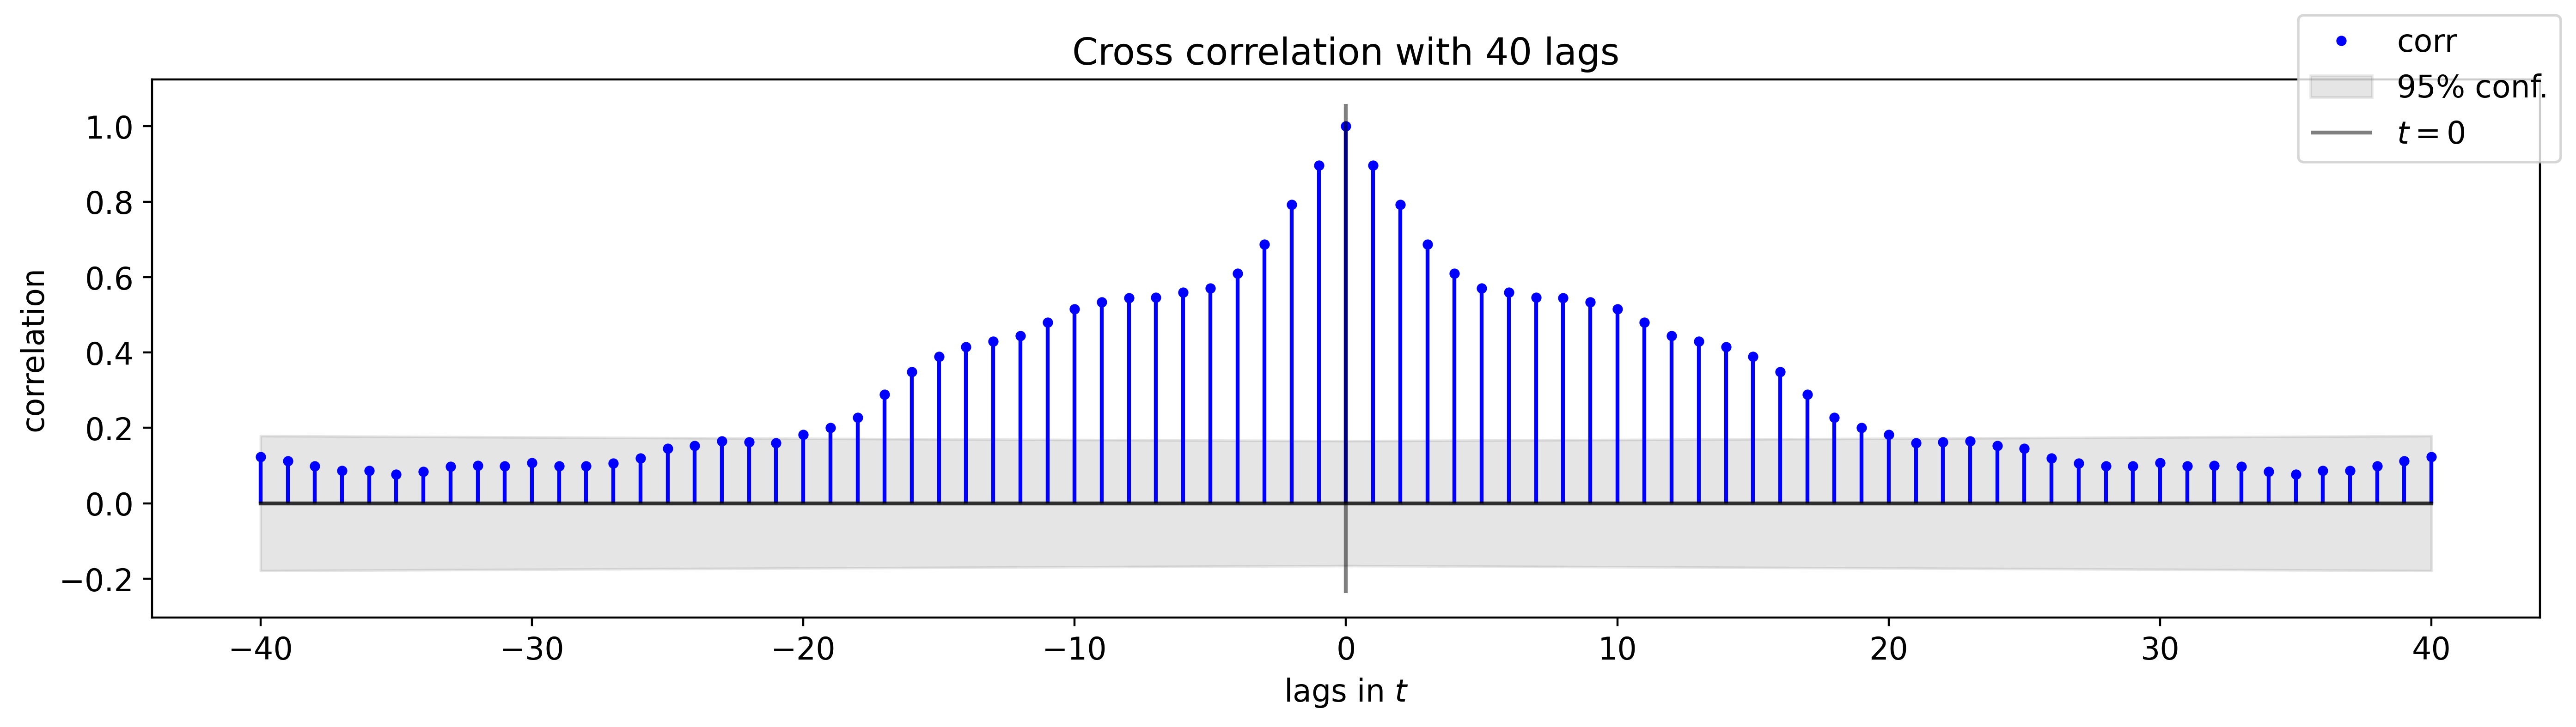

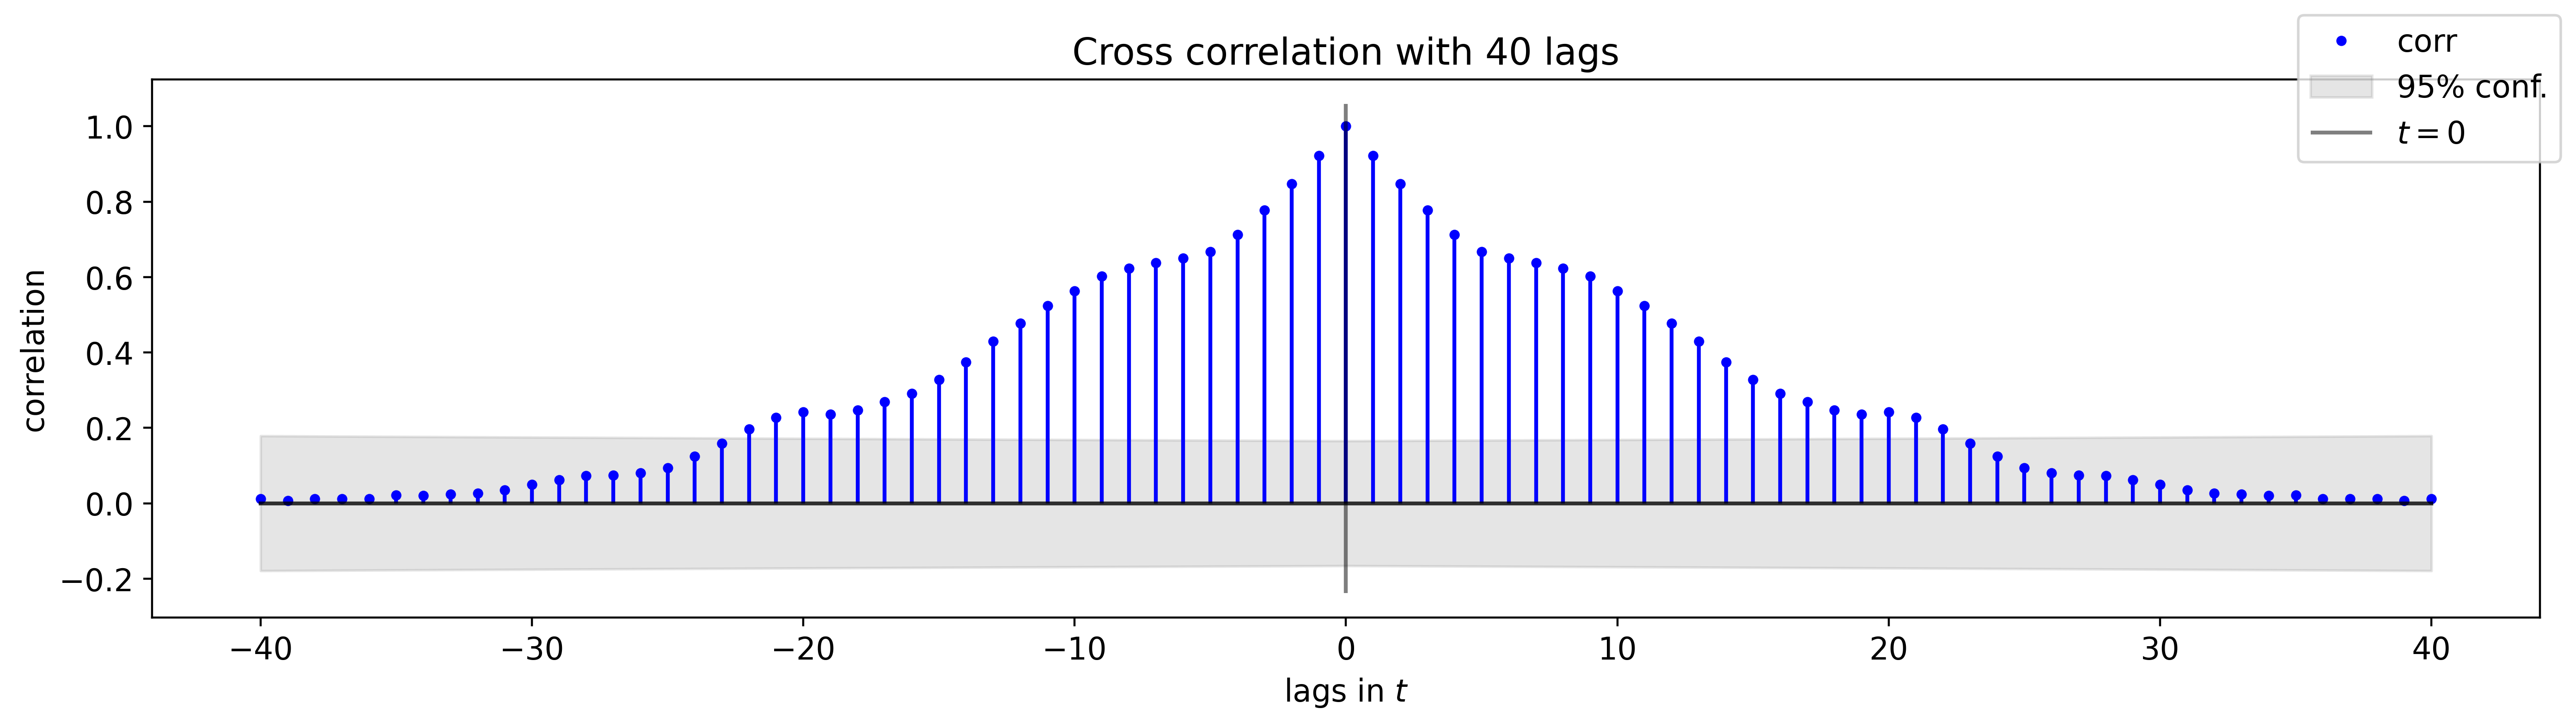

In [8]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, dpi=400, n_lags=40, figsize=(14,4));
fig, ax = fig
save_fig(fig, 'emp_pi_perc_acorr.png')
_, _, _, fig = xcorr(sub2.delta_pe_MY_error_act_WY, dpi=400, n_lags=40, figsize=(14,4));
fig, ax = fig
save_fig(fig, 'emp_delta_pe_acorr.png')

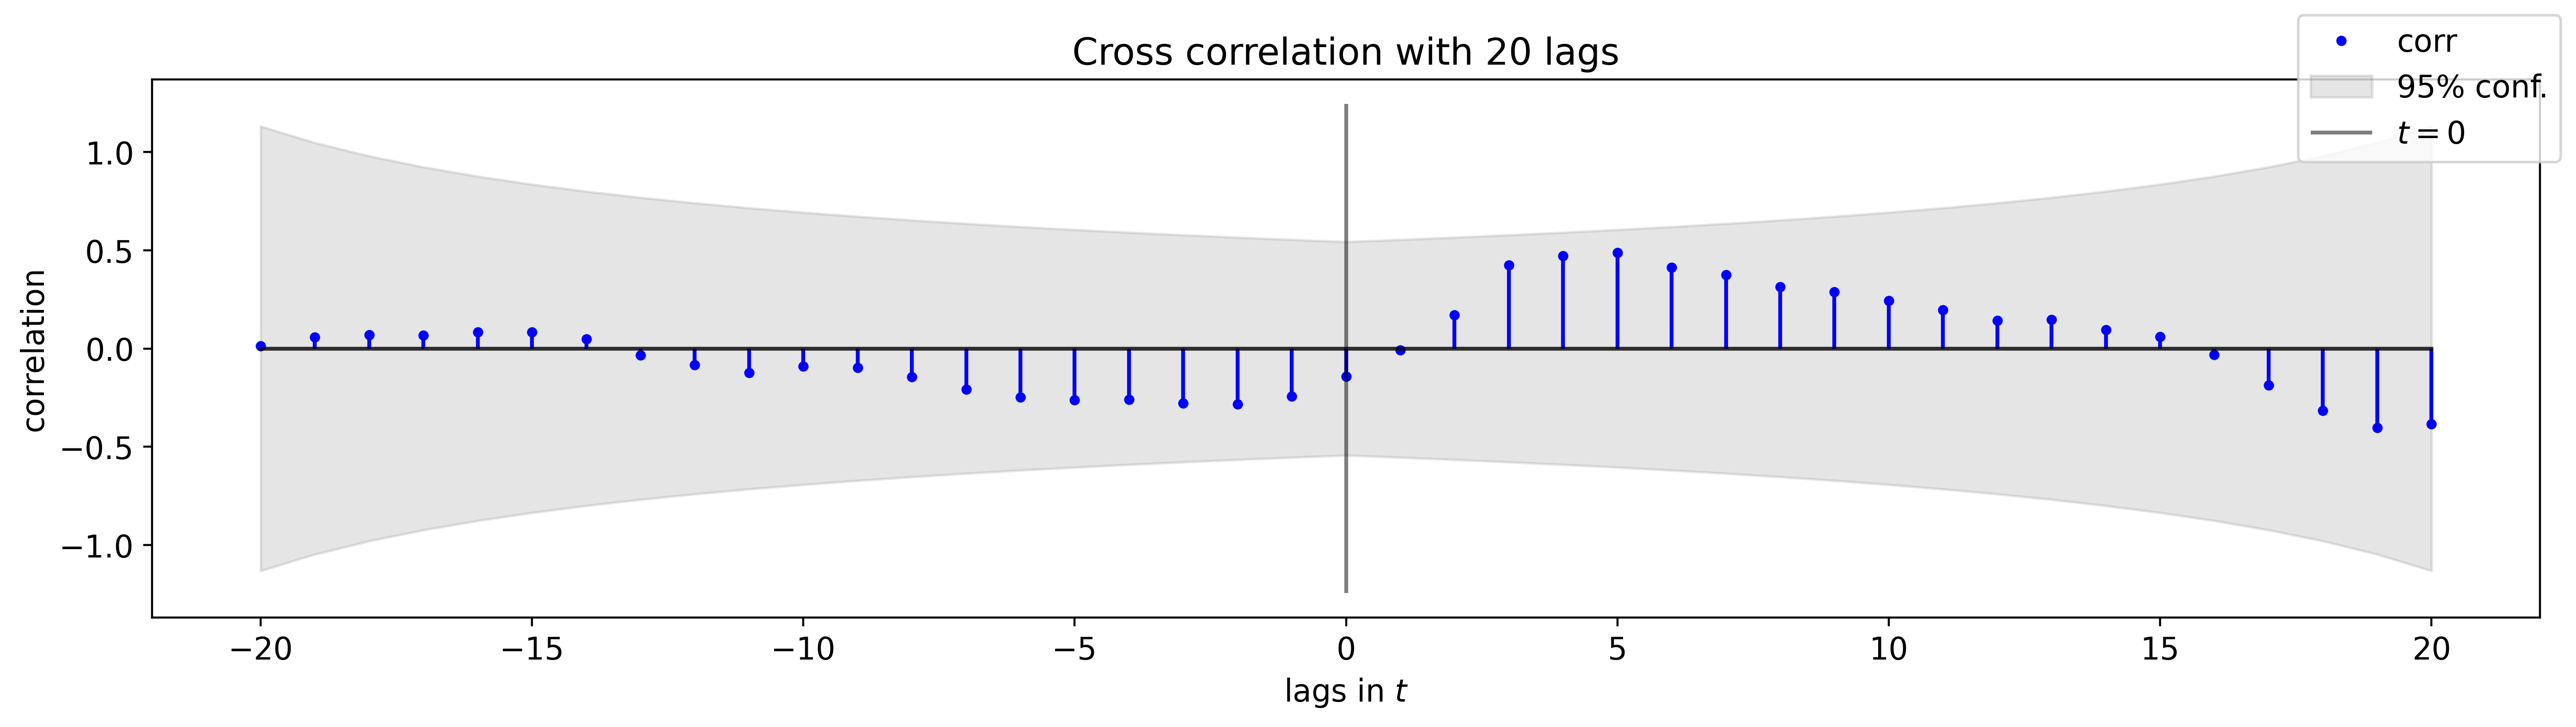

In [9]:
_, _, _, fig = xcorr(sub.pi_perc_MY_all_error_act_MY, sub.pi_de_Y, n_lags=20, dpi=400, figsize=(14,4))
fig, ax = fig
save_fig(fig, 'emp_pi_pe_real_xcorr.png')

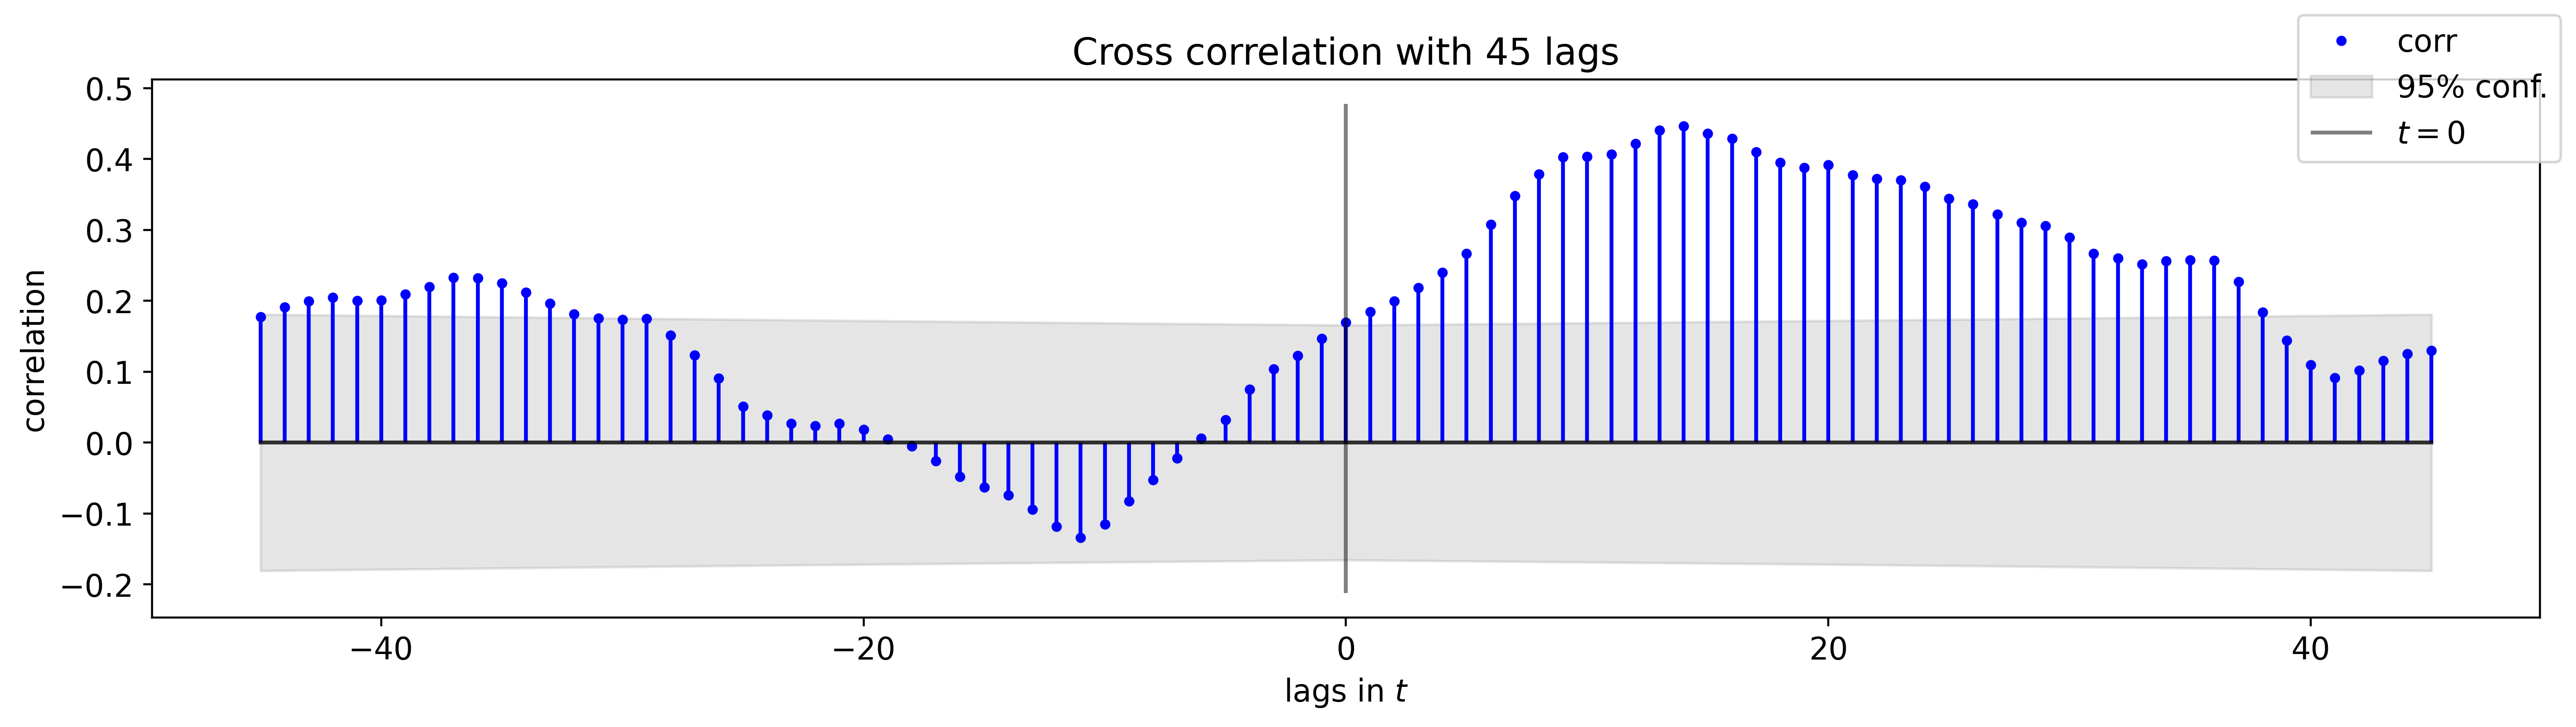

In [10]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, sub2.delta_pe_MY_error_act_WY, n_lags=45,  dpi=400, figsize=(14,4))
fig, ax = fig
save_fig(fig, 'emp_pi_pe_delta_xcorr.png')

## VECM

In [64]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'pi_de_surprise_Y_S', 'delta_pe_MY', 'pi_perc_MY_error_act', 'pi_perc_MY__S_error_act',
                  'pi_de_estimate_Y', 'pi_de_estimate_Y_S', 'pi_exp_MY', 'pi_perc_MY', 'T_sum']
                 , 'M', 'last').dropna()
sub = pd_join_freq(sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
sub['pi_perc_MY_error_act'] /= 100
sub['delta_pe_MY_error_act_MY'] /= 10

### pi perc error

In [67]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y_S', 'pi_de_estimate_Y_S', 'delta_pe_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=3, k_ar_diff=2).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.0016887296385516702
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y_S ADF p-val: 0.06834752672103775
pi_de_estimate_Y_S ADF p-val: 0.33990128620096977
delta_pe_MY ADF p-val: 0.4966952695082546
5
3 3


### pi perc error

In [30]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_error_act ADF p-val: 0.00011267366936239293
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y ADF p-val: 0.06834752672103775
pi_de_estimate_Y ADF p-val: 0.33990128620096977
pi_perc_MY ADF p-val: 0.0016887296385516702
3
2 2


### pi error S

In [65]:
cols_endog, cols_exog = ['pi_perc_MY__S_error_act'], ['T_sum', 'pi_de_surprise_Y_S', 'pi_de_estimate_Y_S', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY__S_error_act ADF p-val: 0.00020682513515031062
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y_S ADF p-val: 0.06834752672103775
pi_de_estimate_Y_S ADF p-val: 0.33990128620096977
pi_perc_MY ADF p-val: 0.0016887296385516702
3
2 2


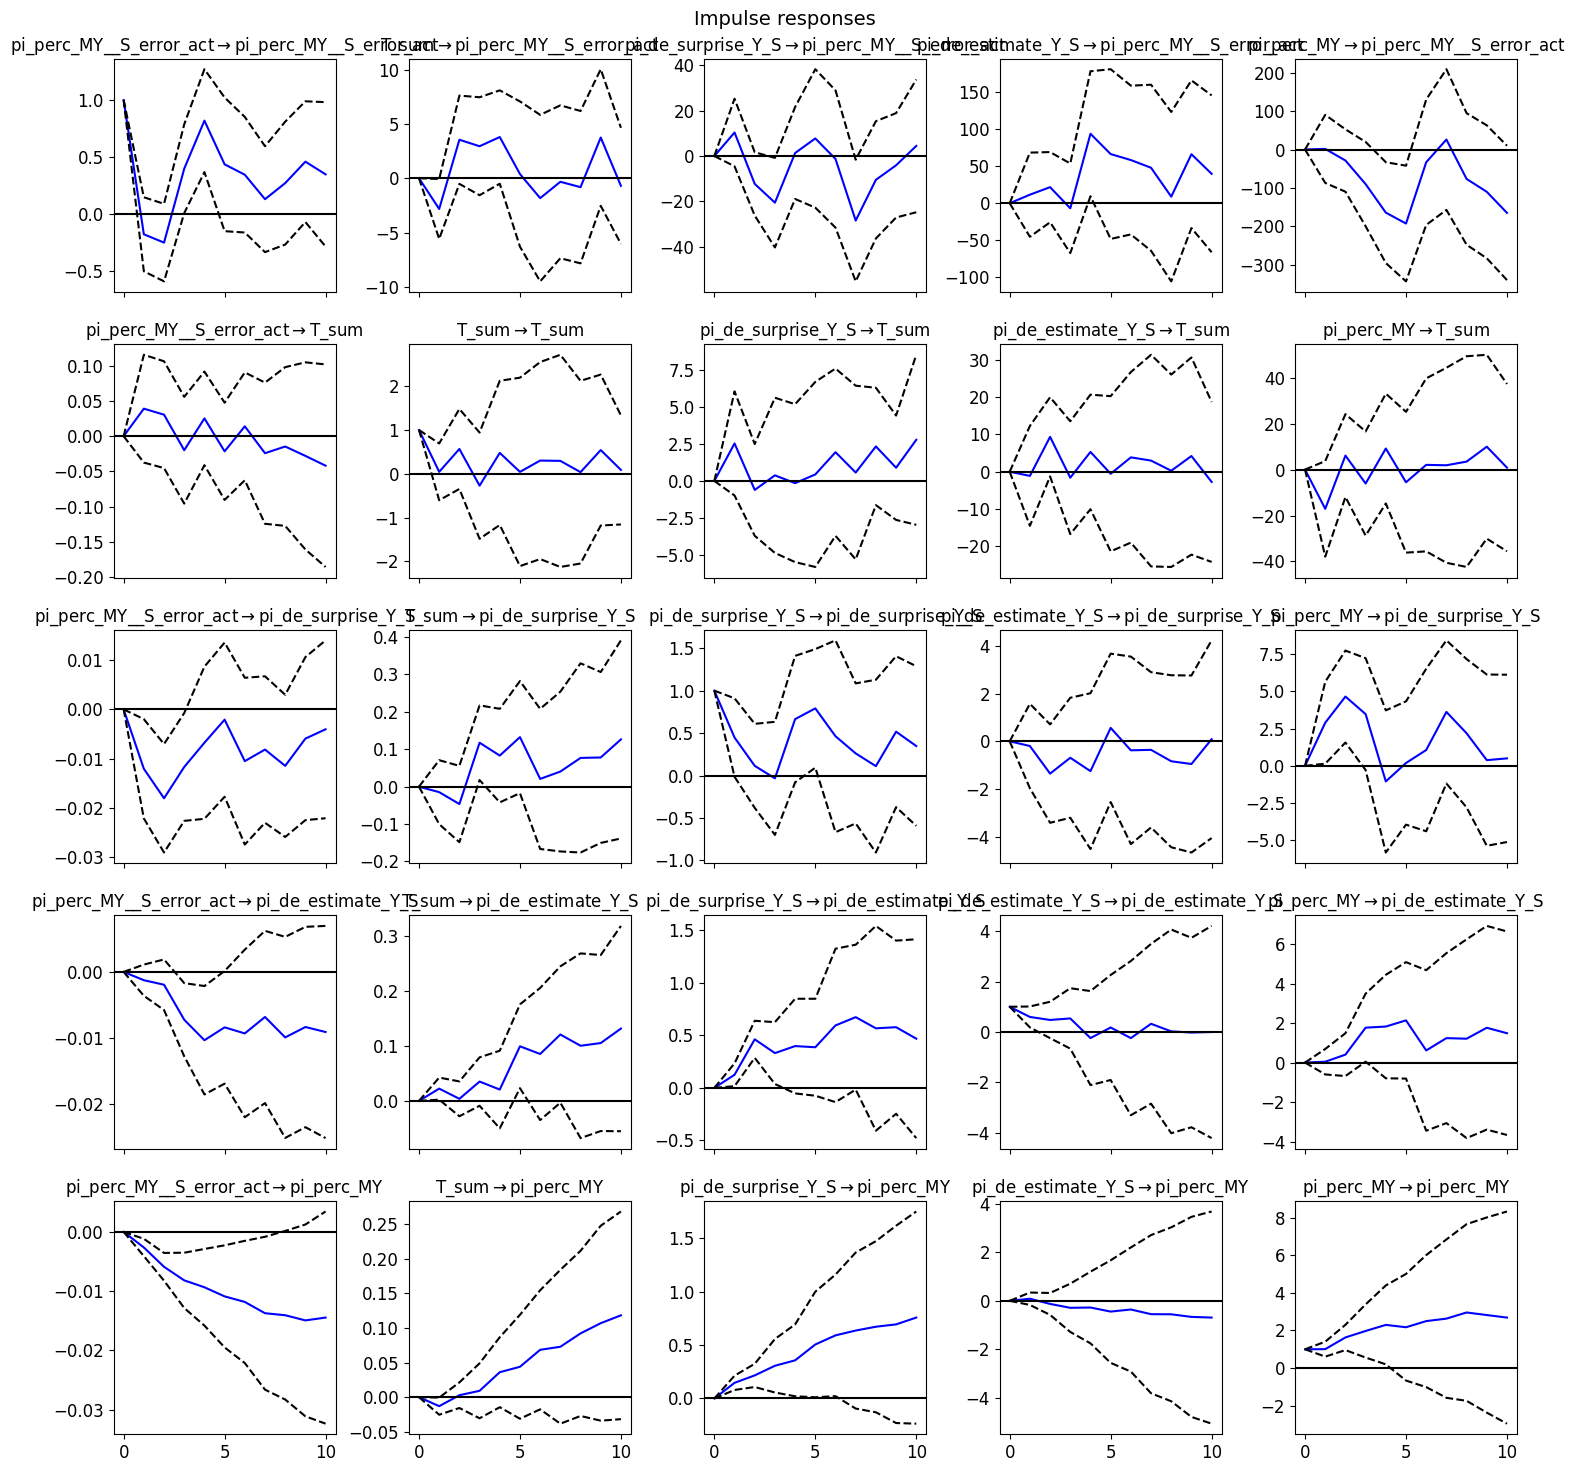

In [66]:
vecm2.irf().plot(figsize=(15,15));
plt.tight_layout()

### delta pe

In [31]:
cols_endog, cols_exog = ['delta_pe_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY ADF p-val: 0.4966952695082546
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y ADF p-val: 0.06834752672103775
pi_de_estimate_Y ADF p-val: 0.33990128620096977
pi_exp_MY ADF p-val: 0.3573249770780111
5
2 2


### delta pe error

In [32]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=2).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.9562165414390092
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y ADF p-val: 0.06834752672103775
pi_de_estimate_Y ADF p-val: 0.33990128620096977
pi_perc_MY ADF p-val: 0.0016887296385516702
2
2 2


### uncertainty

In [33]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_uncertainty_MY ADF p-val: 0.01557256792453695
T_sum ADF p-val: 0.9323959339845194
pi_de_surprise_Y ADF p-val: 0.06834752672103775
pi_de_estimate_Y ADF p-val: 0.33990128620096977
1
3 3


### summary

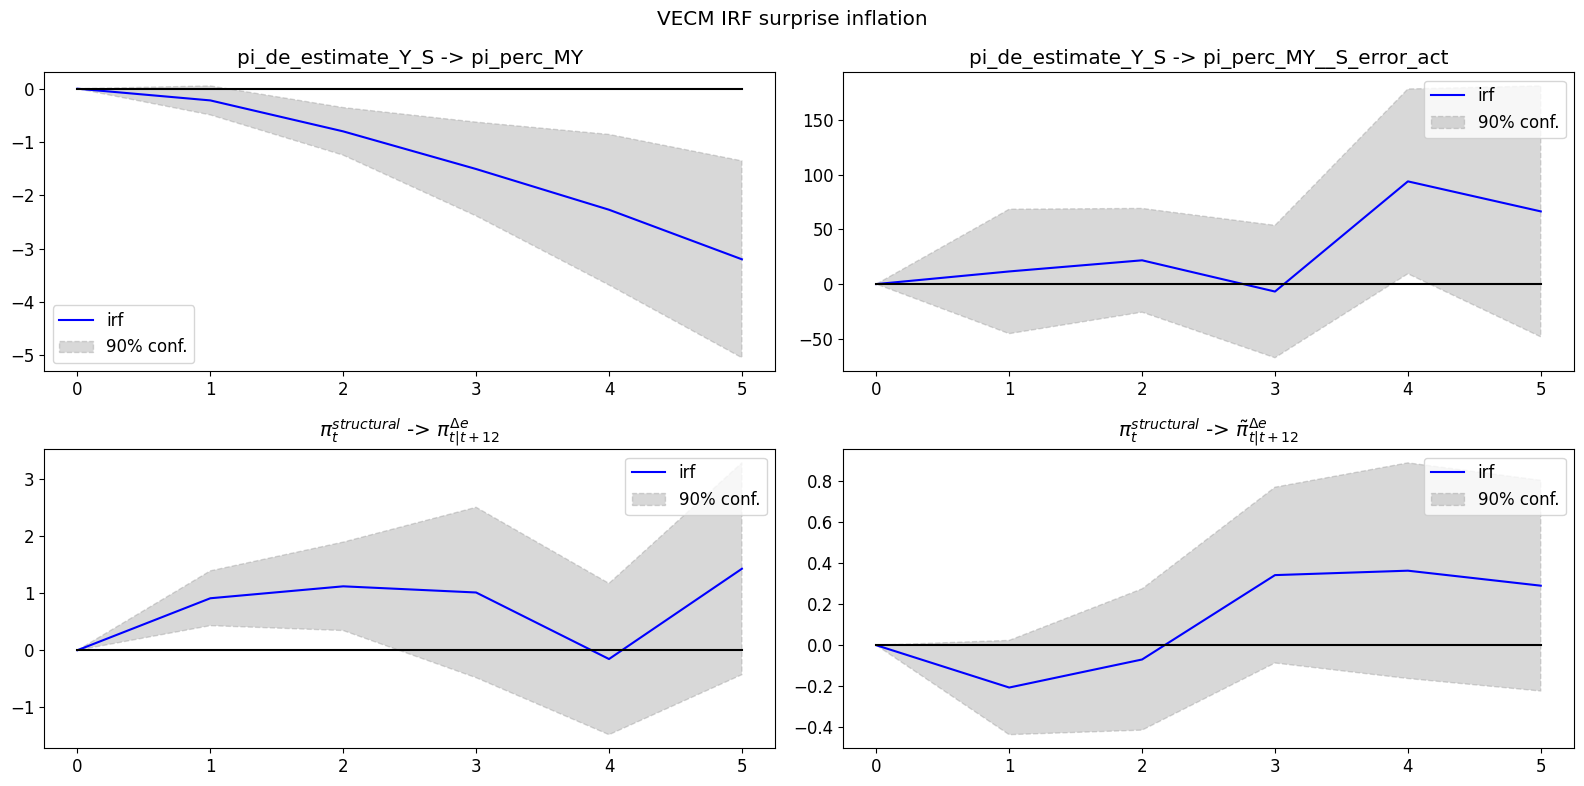

In [68]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4,  ] #vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_de_estimate_Y": "$\pi^{structural}_t$",
                                         },
                             idx_vecm=(0, 3),
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_struct.png")

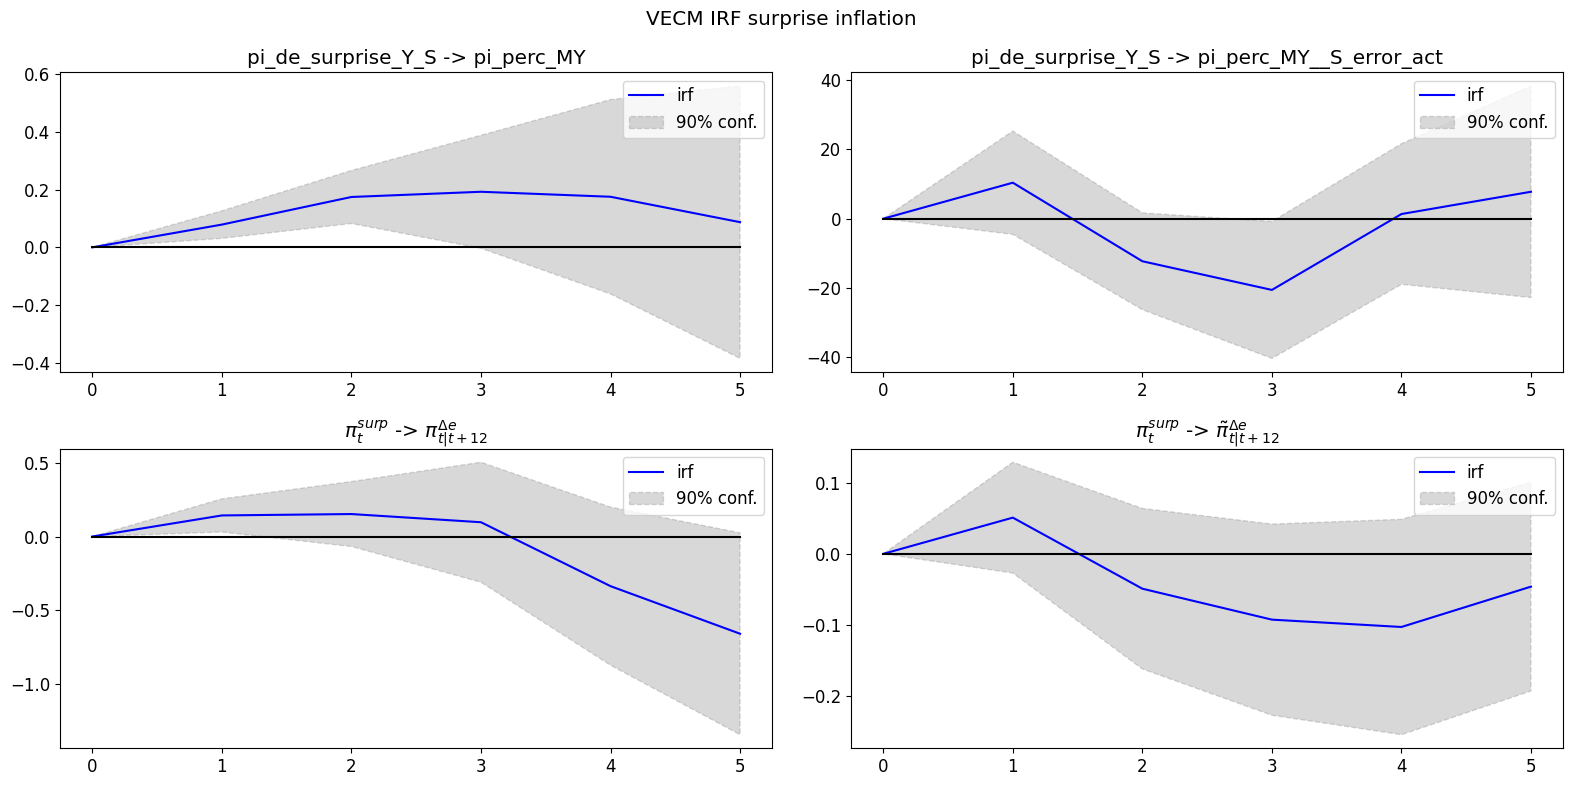

In [69]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4,  ] #vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                         },
                             idx_vecm=(0,2),
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_surp.png", GRAPHS_DIR)

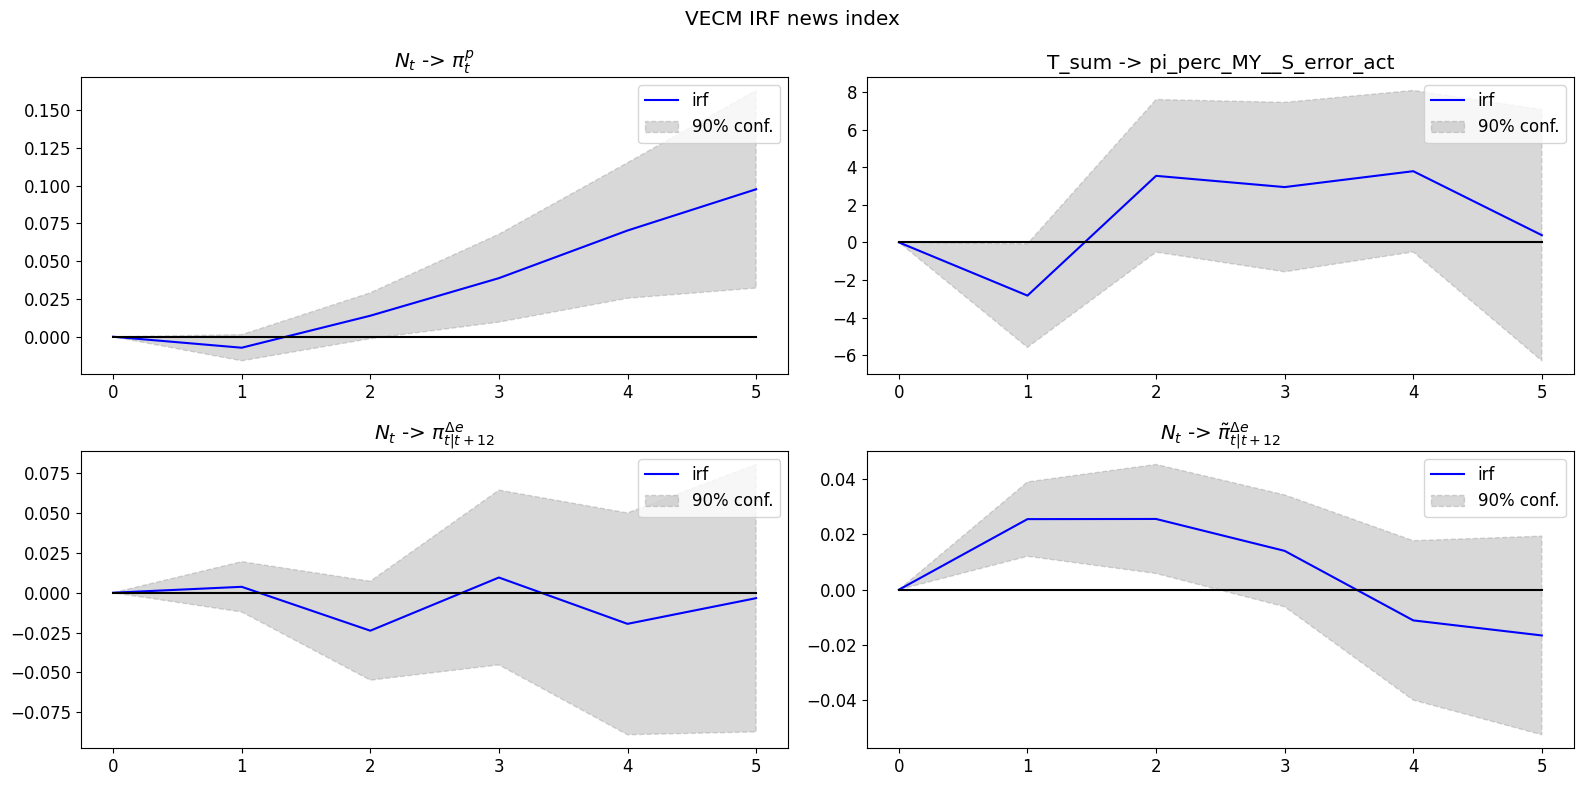

In [70]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                         },
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF news index")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news.png")

In [37]:
out = get_statsmodels_summary(lst_vecms, is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)


In [38]:
out

,delta_pe_MY,delta_pe_MY_error_act_MY,pi_perc_MY,pi_perc_MY_error_act
L1.T_sum,-0.021 \n[-1.513],0.005 \n[0.547],-0.026 **\n[-2.35],-0.025 *\n[-1.814]
L1.delta_pe_MY,0.857 ***\n[4.863],NaN,-0.148 *\n[-1.884],NaN
L1.pi_de_estimate_Y,0.427 *\n[1.664],-0.23 **\n[-1.961],-0.276 **\n[-2.247],-1.174 ***\n[-5.138]
L1.pi_de_surprise_Y,0.224 **\n[2.075],-0.176 ***\n[-2.832],-0.216 ***\n[-3.492],-0.158 \n[-1.183]
L1.pi_perc_MY,NaN,-0.643 ***\n[-3.216],-0.057 \n[-0.358],-0.242 \n[-0.764]
L2.T_sum,-0.071 ***\n[-6.888],-0.018 **\n[-2.159],0.006 \n[0.587],0.052 ***\n[3.057]
L2.delta_pe_MY,-0.7 ***\n[-7.16],NaN,0.312 ***\n[5.004],NaN
L2.delta_pe_MY_error_act_MY,NaN,-0.728 ***\n[-4.175],NaN,NaN
L2.pi_de_surprise_Y,0.12 \n[1.342],-0.084 *\n[-1.759],-0.123 **\n[-2.473],-0.183 \n[-1.6]
L2.pi_exp_MY,-0.923 **\n[-2.464],NaN,NaN,NaN
